In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import wfdb
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
import neurokit2 as nk


In [2]:
data_path = 'Af-Mitdb/'

In [3]:
# Get the list of all record files in the folder
# List of Patients
data = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234',
            '04015', '04043', '04048', '04126', '04746',
            '04908', '04936', '05091', '05121', '05261',
            '06426', '06453', '06995', '07162', '07859',
            '07879', '07910', '08215', '08219', '08378',
            '08405', '08434', '08455']

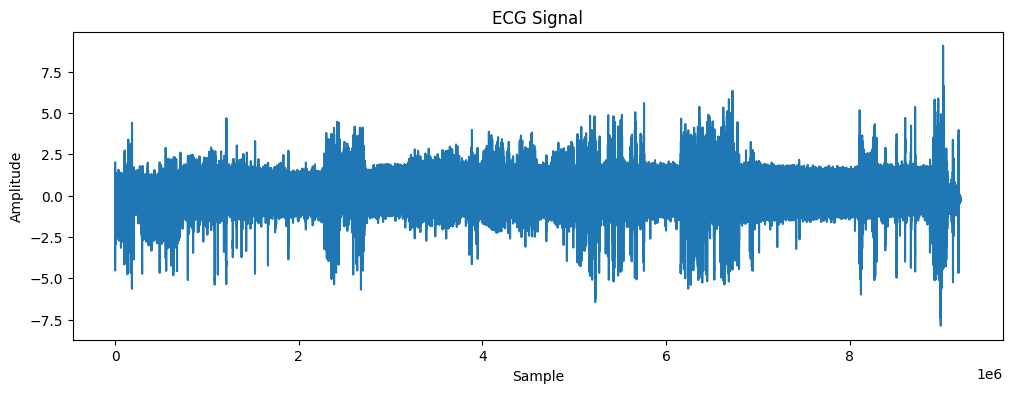

In [4]:
# Creating a Empty Dataframe
symbols_df = pd.DataFrame()

# Reading all .atr files 
for pts in data:
    # Generating filepath for all .atr file names
    file = data_path + pts
    # Saving annotation object
    annotation = wfdb.rdann(file, 'atr')
    # Extracting symbols from the object
    sym = annotation.symbol
    # Saving value counts
    values, counts = np.unique(sym, return_counts=True)
    # Writing data points into dataframe
    df_sub = pd.DataFrame({'symbol':values, 'Counts':counts, 'data Number':[pts]*len(counts)})
    # Concatenating all data points  
    symbols_df = pd.concat([symbols_df, df_sub],axis = 0)

# Loop over all records and load the signal and annotations
for record_name in data:
    record_path = os.path.join(data_path, record_name)
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr', shift_samps=True)
    ecg_signal = record.p_signal[:,0]
    ecg_signal = np.nan_to_num(ecg_signal)

    # Get the signal and labels
    sig = ecg_signal
    labels = np.array(annotation.symbol)

plt.figure(figsize=(12, 4))
plt.plot(sig)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('ECG Signal')
plt.show()

Signal shape: (2301440,)
Labels shape: (4,)


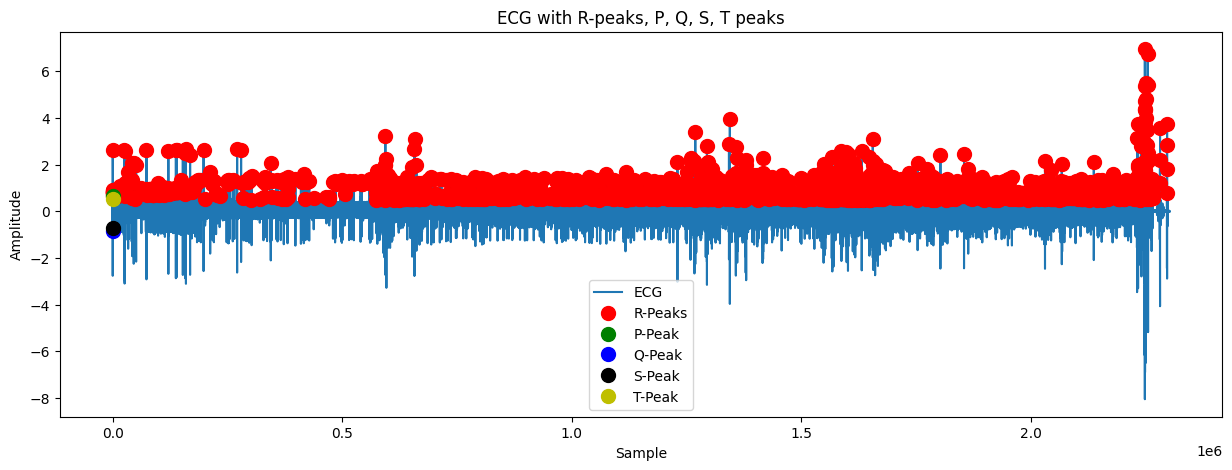

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample, butter, filtfilt, find_peaks
import pywt
from scipy import integrate
import cv2

# Normalize the data
sig = (sig - np.mean(sig)) / np.std(sig)

# Resample the data to new_sampling_rate
new_sampling_rate = 250
record = {"fs": 1000}  # Define the sampling rate
sig_resampled = resample(sig, int(len(sig) * (new_sampling_rate / record["fs"])))

# Bandpass filter the data
lowcut = 5.0
highcut = 15.0
sampling_rate = new_sampling_rate

def bandpass_filter(data, lowcut, highcut, sampling_rate, order=4):
    nyq = 0.5 * sampling_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data


sig_filtered = bandpass_filter(sig_resampled, lowcut, highcut, sampling_rate, order=4)

# detect R-peaks
r_peaks, _ = find_peaks(sig_filtered, height=0.5, distance=100)

# create array for marking detected peaks
peaks = np.zeros_like(sig_filtered)

# mark R-peaks
peaks[r_peaks] = sig_filtered[r_peaks]

# detect P-peaks
p_peaks, _ = find_peaks(sig_filtered[:r_peaks[0]], height=0.1, distance=50)

p_peak = p_peaks[-1] if len(p_peaks) > 0 else None

# detect Q-peaks
if p_peak is not None:
    q_peaks, _ = find_peaks(-sig_filtered[p_peak:r_peaks[0]], height=-0.2, distance=50)
    q_peak = p_peak + q_peaks[-1] if len(q_peaks) > 0 else None
else:
    q_peak = None

# detect S-peaks
s_peaks, _ = find_peaks(-sig_filtered[r_peaks[0]:r_peaks[1]], height=-0.2, distance=50)
s_peak = r_peaks[0] + s_peaks[0] if len(s_peaks) > 0 else None

# detect T-peaks
t_peaks, _ = find_peaks(sig_filtered[r_peaks[1]:], height=0.1, distance=50)
t_peak = r_peaks[1] + t_peaks[0] if len(t_peaks) > 0 else None


# modify conditional statements
if p_peak is not None and len(p_peaks) > 0:
    q_peaks, _ = find_peaks(-sig_filtered[p_peak:r_peaks[0]], height=-0.2, distance=50)
    q_peak = p_peak + q_peaks[-1]
else:
    q_peak = None

if len(s_peaks) > 0:
    s_peak = r_peaks[0] + s_peaks[0]
else:
    s_peak = None

if len(t_peaks) > 0:
    t_peak = r_peaks[1] + t_peaks[0]
else:
    t_peak = None



def wavelet_denoising(data):
    waveletname = 'db6'
    threshold = 0.04
    level = pywt.dwt_max_level(len(data), waveletname)
    coeff = pywt.wavedec(data, waveletname, level=level)
    sigma = threshold*np.median(np.abs(coeff[-level]))
    uthresh = sigma*np.sqrt(2*np.log(len(data)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, waveletname)
    return reconstructed_signal

sig_denoised = wavelet_denoising(sig_filtered)

# Define signal parameters
fs = 1000  # Sampling frequency
f = 500  # ECG frequency
duration = 10  # Signal duration (in seconds)

# Generate time vector
t = np.arange(0, duration, 1/fs)

# Generate ECG signal
sig = integrate.cumulative_trapezoid(np.sin(2*np.pi*f*t), t, initial=0)


# Print the shape of the signal and labels
print("Signal shape:", sig_denoised.shape)
print("Labels shape:", labels.shape)

# plot ECG signal with R-peaks
plt.figure(figsize=(15, 5))
plt.plot(sig_filtered, label='ECG')
plt.plot(r_peaks, peaks[r_peaks], 'or', markersize=10, label='R-Peaks', linestyle='None')

# plot P, Q, S, T peaks
if p_peak is not None:
  plt.plot(p_peak, sig_filtered[p_peak], 'og', markersize=10, label='P-Peak', linestyle='None')
if q_peak is not None:
  plt.plot(q_peak, sig_filtered[q_peak], 'ob', markersize=10, label='Q-Peak', linestyle='None')
if s_peak is not None:
  plt.plot(s_peak, sig_filtered[s_peak], 'ok', markersize=10, label='S-Peak', linestyle='None')
if t_peak is not None:
  plt.plot(t_peak, sig_filtered[t_peak], 'oy', markersize=10, label='T-Peak', linestyle='None')

plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('ECG with R-peaks, P, Q, S, T peaks')
plt.legend()
plt.show()

In [6]:
#show label
wfdb.io.show_ann_labels()
wfdb.io.show_ann_classes()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [7]:
# Symbols Dataframe
symbols_df

,symbol,Counts,data Number
0,+,1,100
1,A,33,100
2,N,2239,100
3,V,1,100
0,+,1,101
...,...,...,...
0,+,79,08219
0,+,17,08378
0,+,4,08405
0,+,7,08434


In [8]:
# Value Counts of Different symbols in data
symbols_df.groupby('symbol').Counts.sum().sort_values(ascending = False)

symbol
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1896
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: Counts, dtype: int64

In [9]:
# Normal Beat Symbols
normal = ['N']

# Abnormal Beat Symbols
AF = ['f']
PAC = ['A']
PVC = ['V']

abnormal_category = AF + PAC + PVC

# Classifying abnormal beats into more specific categories
symbols_df['abnormal_category'] = -1
symbols_df.loc[symbols_df.symbol == 'N','abnormal_category'] = "N"
symbols_df.loc[symbols_df.symbol.isin(AF), 'abnormal_category'] = "AF"
symbols_df.loc[symbols_df.symbol.isin(PAC), 'abnormal_category'] = "PAC"
symbols_df.loc[symbols_df.symbol.isin(PVC), 'abnormal_category'] = "PVC"

# Value counts of different categories
symbols_df.groupby('abnormal_category').Counts.sum()

abnormal_category
-1     27542
AF       982
N      75052
PAC     2546
PVC     7130
Name: Counts, dtype: int64

In [10]:
def load_ecg(file):
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')

    # extracting the signal
    p_signal = record.p_signal

    # extracting symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample

    return p_signal, atr_sym, atr_sample


In [11]:
# Accessing the ecg points for
file = data_path + data[8]

In [12]:
# Accessing the load ECG function and getting annotation.symbol, annotation.sample, signals
p_signal, atr_sym, atr_sample = load_ecg(file)

In [13]:
# Analysing annotations value counts for a single record
values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 4


In [14]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal_category][:10]
ab_index

[4105, 10876, 83824, 107330, 180041, 193553, 205731, 221206, 263192, 268697]

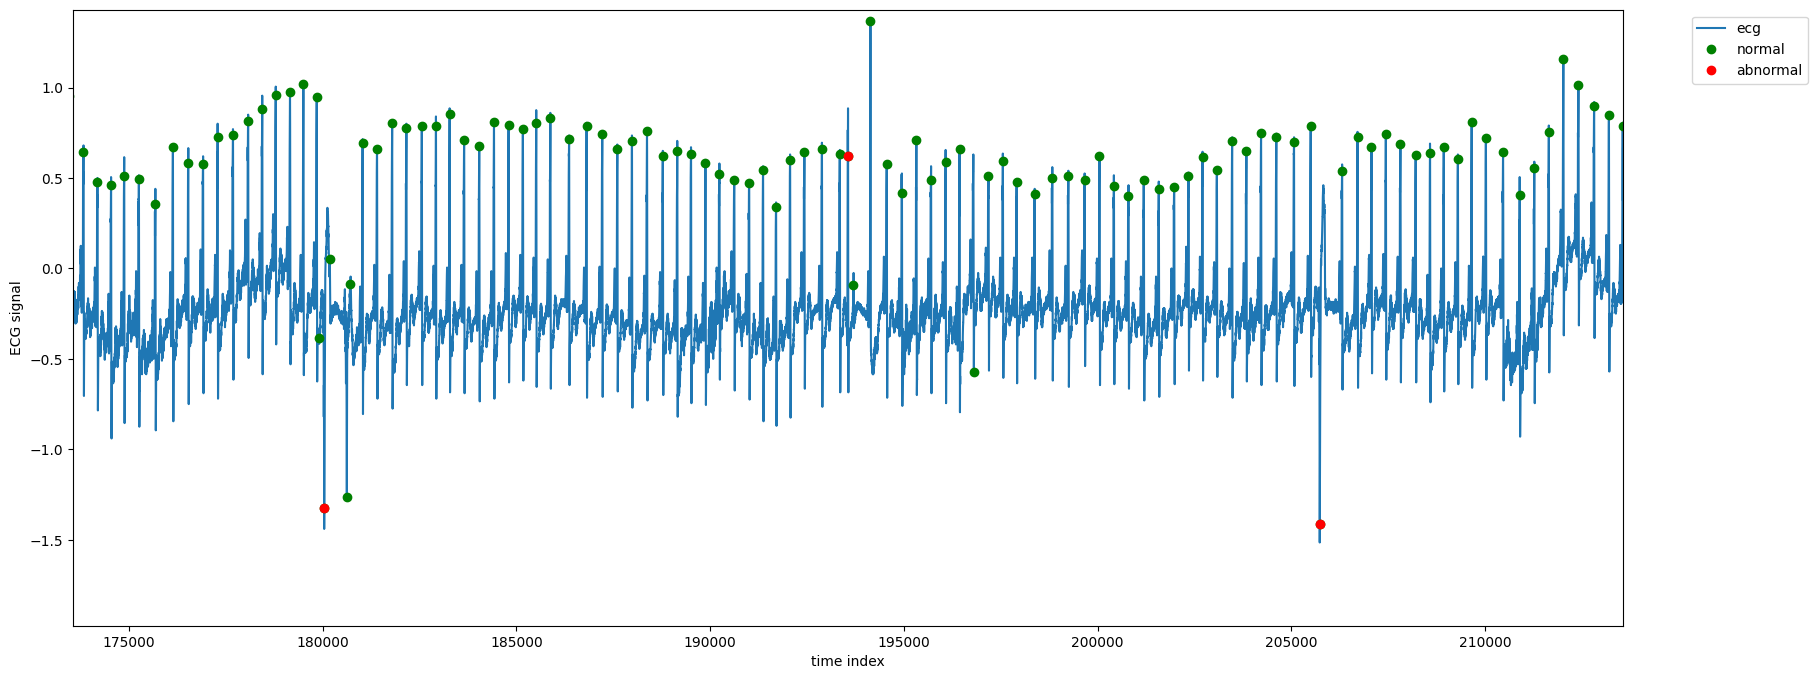

In [15]:
# Generating evenly spaced values
x = np.arange(len(p_signal))

left = ab_index[5]-20000
right = ab_index[5]+20000

plt.figure(figsize=(20,8))
plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

In [16]:
def make_dataset(record_patients, num_sec, fs, abnormal_category):

    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,len(abnormal_category)))
    sym_all = []

    # list to keep track of number of beats across patients
    max_rows = []

    for pt in data:
        file = data_path + pt

        p_signal, atr_sym, atr_sample = load_ecg(file)

        # grab the first signal
        p_signal = p_signal[:,0]

        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal_category)]

        num_rows = len(df_ann)

        X = np.zeros((num_rows, num_cols))
        Y = np.zeros((num_rows, len(abnormal_category)))
        sym = []

        # keep track of rows
        max_row = 0

        for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

            left = max([0,(atr_sample - num_sec*fs) ])
            right = min([len(p_signal),(atr_sample + num_sec*fs) ])
            x = p_signal[left: right]
            if len(x) == num_cols:
                X[max_row,:] = x
                Y[max_row, abnormal_category.index(atr_sym)] = 1
                sym.append(atr_sym)
                max_row += 1
        X = X[:max_row,:]
        Y = Y[:max_row,:]

        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)

    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]

    return X_all, Y_all, sym_all


  abnormal_category  Counts
0                -1   27542
1                AF     982
2                 N   75052
3               PAC    2546
4               PVC    7130


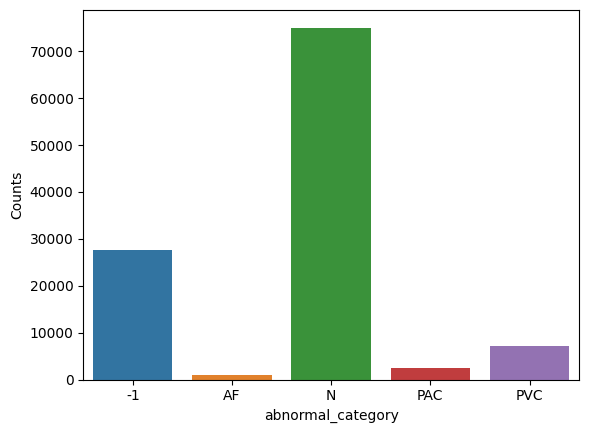

In [17]:
import seaborn as sns
# Value counts of different categories
counts_df = symbols_df.groupby('abnormal_category')['Counts'].sum().reset_index()
print(counts_df)

# Visualize the number of subjects in each abnormal_category:
sns.barplot(x='abnormal_category', y='Counts', data=counts_df)
plt.show()


In [18]:
import numpy as np
from scipy.stats import kurtosis, skew
from scipy.fft import fft

def extract_features(rr_intervals):
    features = {}

    # RR Interval Features
    rr_mean = np.mean(rr_intervals)
    rr_std = np.std(rr_intervals)
    rr_min = np.min(rr_intervals)
    rr_max = np.max(rr_intervals)
    rr_range = rr_max - rr_min
    rr_median = np.median(rr_intervals)
    rr_diff = np.diff(rr_intervals)
    rr_fft = np.abs(fft(rr_intervals))
    rr_skewness = skew(rr_intervals)
    rr_kurtosis = kurtosis(rr_intervals)

    features['RR Mean'] = rr_mean
    features['RR Std'] = rr_std
    features['RR Min'] = rr_min
    features['RR Max'] = rr_max
    features['RR Range'] = rr_range
    features['RR Median'] = rr_median
    features['RR Skewness'] = rr_skewness
    features['RR Kurtosis'] = rr_kurtosis

    features['mean_rr_diff'] = np.mean(rr_diff)
    features['std_rr_diff'] = np.std(rr_diff)
    features['min_rr_diff'] = np.min(rr_diff)
    features['max_rr_diff'] = np.max(rr_diff)
    features['median_rr_diff'] = np.median(rr_diff)
    features['range_rr_diff'] = np.ptp(rr_diff)

    features['RR FFT Mean'] = np.mean(rr_fft)
    features['RR FFT Std'] = np.std(rr_fft)
    features['RR FFT Max'] = np.max(rr_fft)

    rr_variance = np.var(rr_intervals)
    rr_coefficient_of_variation = np.mean(rr_intervals) / np.std(rr_intervals)

    features['RR Variance'] = rr_variance
    features['RR Coefficient of Variation'] = rr_coefficient_of_variation

    # Additional Statistical Features
    features['RR 5th Percentile'] = np.percentile(rr_intervals, 5)
    features['RR 95th Percentile'] = np.percentile(rr_intervals, 95)
    features['RR Interquartile Range'] = np.percentile(rr_intervals, 75) - np.percentile(rr_intervals, 25)

    # Additional Dynamic Features
    rr_diff_mean = np.mean(rr_diff)
    rr_diff_std = np.std(rr_diff)
    rr_diff_min = np.min(rr_diff)
    rr_diff_max = np.max(rr_diff)
    rr_diff_median = np.median(rr_diff)
    rr_diff_range = np.ptp(rr_diff)

    features['mean_rr_diff'] = rr_diff_mean
    features['std_rr_diff'] = rr_diff_std
    features['min_rr_diff'] = rr_diff_min
    features['max_rr_diff'] = rr_diff_max
    features['median_rr_diff'] = rr_diff_median
    features['range_rr_diff'] = rr_diff_range


    return features

In [19]:
import matplotlib.pyplot as plt

# Set the parameters
num_sec = 3
fs = 360

# Accessing the function and creating a dataset with ECG digital points
X_all, Y_all, sym_all = make_dataset(data, num_sec, fs, abnormal_category)

# Mengambil segmen RR interval
rr_intervals = X_all[:, fs * num_sec:]

features = []
for rr in rr_intervals:
    feature = extract_features(rr)
    features.append(feature)

# Convert the features list to a dataframe
df_features = pd.DataFrame(features)

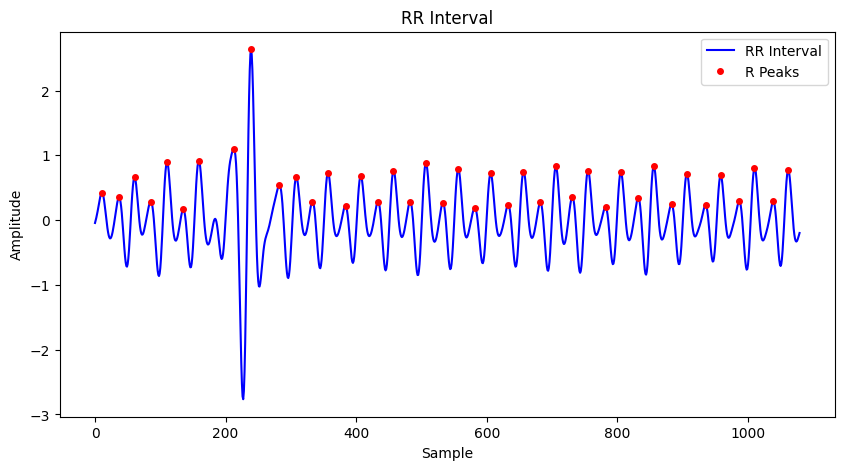

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

r_peaks, _ = find_peaks(sig_denoised[:len(rr_intervals[0])], prominence=0.4)

# Plot the QRS complexes with R, Q, and S peaks
plt.figure(figsize=(10, 5))
plt.plot(sig_denoised[:len(rr_intervals[0])], color='blue', label='RR Interval')
plt.plot(r_peaks, sig_denoised[r_peaks], 'ro', markersize=4, label='R Peaks')

plt.title('RR Interval')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

# Initialize K-fold cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize arrays to store evaluation metrics
accuracies = []
sensitivities = []
specificities = []
classification_reports = []
confusion_matrices = []

# Assuming df_features and Y_all are defined
for train_index, test_index in kf.split(df_features):
    X_train, X_val = df_features.iloc[train_index[:-50]].values, df_features.iloc[train_index[-50:]].values
    Y_train, Y_val = Y_all[train_index[:-50]], Y_all[train_index[-50:]]
    X_test, Y_test = df_features.iloc[test_index].values, Y_all[test_index]

    # Normalization using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Reshape input data to match the LSTM input shape
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Ensure Y_train and Y_test are 1D arrays
    Y_train = np.squeeze(Y_train)
    Y_test = np.squeeze(Y_test)

    # Number of classes for multi-label classification
    num_classes = Y_train.shape[1]

    # Build the LSTM model for multi-label classification
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='sigmoid'))  # Use sigmoid for multi-label classification
    
    # Early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

    # Evaluate the model
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions
    
    # Calculate TP and FN for each class
    true_positives = np.sum((Y_test == 1) & (y_pred == 1), axis=0)
    false_negatives = np.sum((Y_test == 1) & (y_pred == 0), axis=0)
    
    # Calculate sensitivity for each class and append to the list
    sensitivity = true_positives / (true_positives + false_negatives)
    sensitivities.append(sensitivity)
    
    # Calculate TN and FP for each class
    true_negatives = np.sum((Y_test == 0) & (y_pred == 0), axis=0)
    false_positives = np.sum((Y_test == 0) & (y_pred == 1), axis=0)
    
    # Calculate specificity for each class and append to the list
    specificity = true_negatives / (true_negatives + false_positives)
    specificities.append(specificity)
    
    # Calculate confusion matrix for each class
    conf_matrix = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])
    confusion_matrices.append(conf_matrix)
    
    
    # Calculate overall accuracy
    accuracy = accuracy_score(Y_test, y_pred) * 100

    # Generate classification report
    class_names = [f'Class {i}' for i in range(num_classes)]  # Adjust class names as needed
    class_report = classification_report(Y_test, y_pred, target_names=class_names, labels=range(num_classes), zero_division=1)

    # Append metrics to arrays
    accuracies.append(accuracy)
    classification_reports.append(class_report)

    # Print metrics
    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Sensitivity (True Positive Rate): {sensitivity}')
    print(f'Specificity (True Negative Rate): {specificity}')
    print('Classification Report:')
    print(class_report)

# Calculate mean sensitivity in percentages
mean_sensitivity = np.mean(sensitivities, axis=0) * 100

# Calculate mean specificity in percentages
mean_specificity = np.mean(specificities, axis=0) * 100

# Calculate mean accuracy
mean_accuracy = np.mean(accuracies)

# Print mean values
print(f'Mean Accuracy: {mean_accuracy:.2f}%')

# Print mean sensitivity in percentages
print('Mean Sensitivity:')
print(mean_sensitivity)

# Print mean specificity in percentages
print('Mean Specificity:')
print(mean_specificity)

# Calculate mean confusion matrix
mean_conf_matrix = np.mean(confusion_matrices, axis=0)

# Print mean confusion matrix
print('Mean Confusion Matrix:')
print(mean_conf_matrix)

Epoch 1/100
106/106 [==============================] - 8s 40ms/step - loss: 0.4625 - accuracy: 0.7395 - val_loss: 0.4954 - val_accuracy: 0.3891
Epoch 2/100
106/106 [==============================] - 3s 31ms/step - loss: 0.3451 - accuracy: 0.7968 - val_loss: 0.5326 - val_accuracy: 0.3838
Epoch 3/100
106/106 [==============================] - 3s 31ms/step - loss: 0.2814 - accuracy: 0.8446 - val_loss: 0.5771 - val_accuracy: 0.3921
Epoch 4/100
106/106 [==============================] - 3s 32ms/step - loss: 0.2640 - accuracy: 0.8585 - val_loss: 0.4700 - val_accuracy: 0.4441
Epoch 5/100
106/106 [==============================] - 4s 39ms/step - loss: 0.2493 - accuracy: 0.8711 - val_loss: 0.7582 - val_accuracy: 0.3933
Epoch 6/100
106/106 [==============================] - 6s 52ms/step - loss: 0.2400 - accuracy: 0.8795 - val_loss: 0.7077 - val_accuracy: 0.4299
Epoch 7/100
106/106 [==============================] - 6s 52ms/step - loss: 0.2264 - accuracy: 0.8793 - val_loss: 0.4247 - val_accuracy:

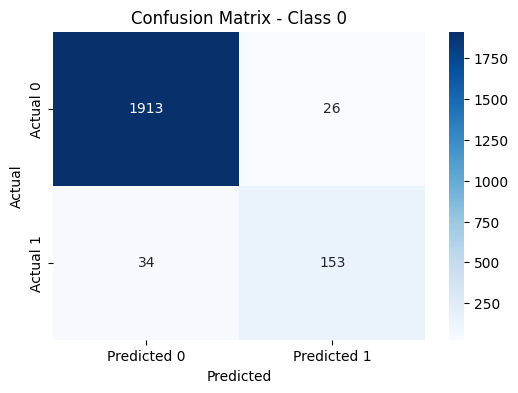

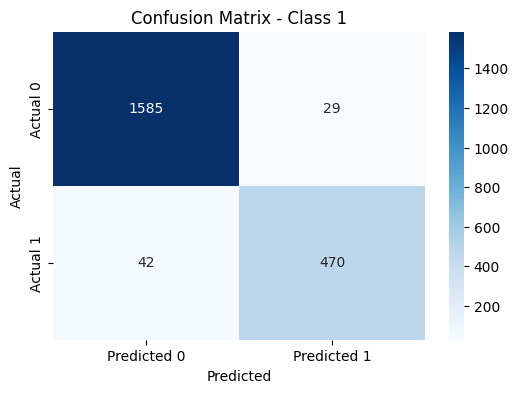

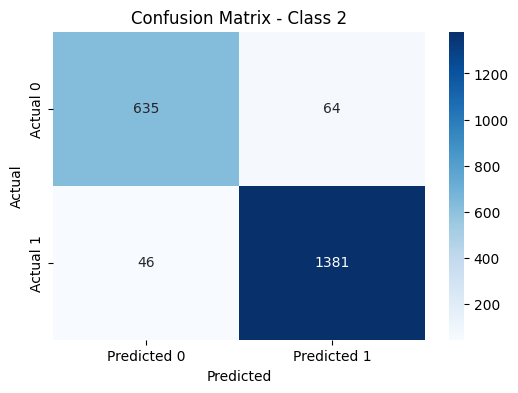

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize an empty list to store confusion matrix plots
confusion_matrix_plots = []

# Generate confusion matrix plot for each class
for class_idx in range(num_classes):
    class_conf_matrix = conf_matrix[:, :, class_idx]  # Get the class-specific confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(class_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Class {class_idx}')
    plt.show()
    confusion_matrix_plots.append(plt)